In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def running_avg(x):
    return np.cumsum(x) / np.arange(1, x.size + 1)

def running_timeavg(t,x):
    dt = t[1:] - t[:-1]
    x = np.cumsum(x[:-1] * dt)
    y = t[1:]
    return [a/b for a,b in zip(x,y)]

def filter_vec(df, name):
    x = df[(df.name == name + ":vector") & (df.type == "vector")] #.filter(["vectime","vecvalue"])
    return x #pd.DataFrame(index=x.vectime.values[0], data={name : x.vecvalue.values[0]})
    
#for i in range(1,len(vec)):
#    row = vec.iloc[i]
#    row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
#    mean_res = pd.concat((mean_res, row)    
#mean_res = mean_res_dc.groupby(level=0).mean()

## Caso DC - Recursos

In [3]:
# Cargamos los datos
targetDcRes = pd.read_csv("targetDcRes.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetDcRes[targetDcRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
97,targetDc-0-20240614-22:02:03-81875,vector,BigNet.dc.resourceManager,allocatedVms:vector,NaN,None,NaN,"[64.206779227439, 64.675951528257, 64.94929069...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
100,targetDc-0-20240614-22:02:03-81875,vector,BigNet.dc.resourceManager,allocatedCores:vector,NaN,None,NaN,"[64.206779227439, 64.675951528257, 64.94929069...","[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ..."
103,targetDc-0-20240614-22:02:03-81875,vector,BigNet.dc.resourceManager,allocatedRam:vector,NaN,None,NaN,"[64.206779227439, 64.675951528257, 64.94929069...","[8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, ..."
107,targetDc-0-20240614-22:02:03-81875,vector,BigNet.dc.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[64.206779227439, 64.675951528257, 64.94929069...","[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...."


In [4]:
def process_vector(df, data_name: str):
    # Empezamos el proceso de merging del conjunto de datos
    row = df.iloc[0]
    print(type(row.vectime))
    print(type(row.vecvalue))
    
    times = np.append([0], row.vectime)
    times = np.append(times, [3600])
    
    # Accumulate the values
    values = np.cumsum(row.vecvalue)
    values = np.append([0], values)
    values = np.append(values, max(values))
    
    vec = pd.DataFrame(index=times, data={data_name : values})
    
    return vec

In [5]:
res_dc = dict()
res_dc["vms"] = process_vector(filter_vec(targetDcRes, "allocatedVms"), "vms")
res_dc["ram"] = process_vector(filter_vec(targetDcRes, "allocatedRam"), "ram")
res_dc["disk"] = process_vector(filter_vec(targetDcRes, "allocatedDisk"), "disk")
res_dc["cpus"] = process_vector(filter_vec(targetDcRes, "allocatedCores"), "cpus")
res_dc["vms"]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,vms
0.000000,0.0
64.206779,1.0
64.675952,2.0
64.949291,3.0
65.086455,4.0
...,...
87.669733,97.0
87.730726,98.0
87.818079,99.0
92.789399,100.0


## Gráficas

In [6]:
dc_num_blades = 40
dc_max_vms = dc_num_blades*16
dc_max_ram = dc_num_blades*64
dc_max_disk = dc_num_blades*4000
dc_max_cpus = dc_num_blades*16

In [7]:
def plot_under_curve(axis, x, y ,color):
    axis.plot(x,y, color=color)
    axis.fill_between(x,y.reshape(-1),0, color=color, alpha=.1)

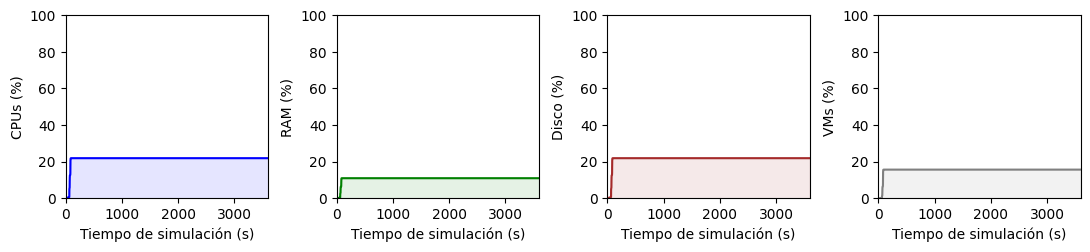

In [32]:
fig, (ax) = plt.subplots(1, 4, figsize=(10,7))
#fig.suptitle('Consumo recursos del Dc')

fig.tight_layout()
fig.set_size_inches(11, 2)

ax[0].set(ylabel='CPUs (%)')
ax[1].set(ylabel='RAM (%)')
ax[2].set(ylabel='Disco (%)')
ax[3].set(ylabel='VMs (%)')

#ax[0].plot(res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100)
#ax[0].fill_between(res_dc["cpus"].index.to_numpy(), (res_dc["cpus"].values.reshape(-1) / dc_max_vms) * 100, 0, color='blue', alpha=.1)

plot_under_curve(ax[0], res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100, "blue")
plot_under_curve(ax[1], res_dc["ram"].index, (res_dc["ram"].values / dc_max_ram) * 100, "green")
plot_under_curve(ax[2], res_dc["disk"].index, (res_dc["disk"].values / dc_max_disk) * 100, "brown")
plot_under_curve(ax[3], res_dc["vms"].index, (res_dc["vms"].values / dc_max_vms) * 100, "gray")

#plt.title("Uso de máquinas virtuales (DC)")

#plt.ylabel("Máquinas virtuales")
#plt.xlabel("tiempo simulado [s]")
for x in ax:
    x.set_ylim(0,100)
    x.set_xlim(0,3600)
    x.set(xlabel='Tiempo de simulación (s)')

fig.savefig("bigResDc.pdf", bbox_inches='tight')
#plt.xlim(0,3600)
#plt.plot(res_dc["vms"])
#plt.show()

## Caso Fog - Recursos

In [9]:
# Cargamos los datos
targetDcRes2 = pd.read_csv("targetFogRes2.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

res_dc2 = dict()
res_dc2["vms"] = process_vector(filter_vec(targetDcRes2, "allocatedVms"), "vms")
res_dc2["ram"] = process_vector(filter_vec(targetDcRes2, "allocatedRam"), "ram")
res_dc2["disk"] = process_vector(filter_vec(targetDcRes2, "allocatedDisk"), "disk")
res_dc2["cpus"] = process_vector(filter_vec(targetDcRes2, "allocatedCores"), "cpus")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


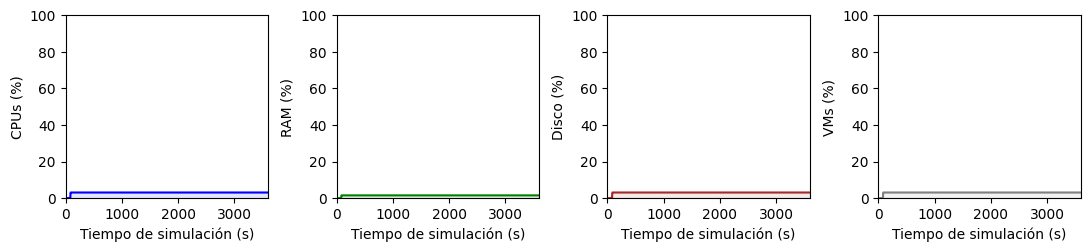

In [31]:
fig, (ax) = plt.subplots(1, 4, figsize=(10,7))
#fig.suptitle('Consumo recursos del Fog')

fig.tight_layout()
fig.set_size_inches(11, 2)

ax[0].set(ylabel='CPUs (%)')
ax[1].set(ylabel='RAM (%)')
ax[2].set(ylabel='Disco (%)')
ax[3].set(ylabel='VMs (%)')

#ax[0].plot(res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100)
#ax[0].fill_between(res_dc["cpus"].index.to_numpy(), (res_dc["cpus"].values.reshape(-1) / dc_max_vms) * 100, 0, color='blue', alpha=.1)

plot_under_curve(ax[0], res_dc2["cpus"].index, (res_dc2["cpus"].values / dc_max_vms) * 100, "blue")
plot_under_curve(ax[1], res_dc2["ram"].index, (res_dc2["ram"].values / dc_max_ram) * 100, "green")
plot_under_curve(ax[2], res_dc2["disk"].index, (res_dc2["disk"].values / dc_max_disk) * 100, "brown")
plot_under_curve(ax[3], res_dc2["vms"].index, (res_dc2["vms"].values / dc_max_vms) * 100, "gray")

#plt.title("Uso de máquinas virtuales (DC)")

#plt.ylabel("Máquinas virtuales")
#plt.xlabel("tiempo simulado [s]")
for x in ax:
    x.set_ylim(0,100)
    x.set_xlim(0,3600)
    x.set(xlabel='Tiempo de simulación (s)')
    
fig.savefig("bigResFog2.pdf", bbox_inches='tight')

In [11]:
# Cargamos los datos
targetFogRes = pd.read_csv("targetFogRes1.csv",converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray})

# Sacamos solo los vectores
proc = targetFogRes[targetFogRes.type == "vector"]
proc

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
116,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgE1.resourceManager,allocatedVms:vector,NaN,None,NaN,"[64.035358010981, 64.884249038059]","[1.0, 1.0]"
119,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgE1.resourceManager,allocatedCores:vector,NaN,None,NaN,"[64.035358010981, 64.884249038059]","[4.0, 4.0]"
122,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgE1.resourceManager,allocatedRam:vector,NaN,None,NaN,"[64.035358010981, 64.884249038059]","[8.0, 8.0]"
126,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgE1.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[64.035358010981, 64.884249038059]","[1000.0, 1000.0]"
130,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgD1.resourceManager,allocatedVms:vector,NaN,None,NaN,"[64.480734905359, 70.598138512107]","[1.0, 1.0]"
133,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgD1.resourceManager,allocatedCores:vector,NaN,None,NaN,"[64.480734905359, 70.598138512107]","[4.0, 4.0]"
136,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgD1.resourceManager,allocatedRam:vector,NaN,None,NaN,"[64.480734905359, 70.598138512107]","[8.0, 8.0]"
140,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgD1.resourceManager,allocatedDisk:vector,NaN,None,NaN,"[64.480734905359, 70.598138512107]","[1000.0, 1000.0]"
144,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgB1.resourceManager,allocatedVms:vector,NaN,None,NaN,"[64.781137665525, 65.280133005641]","[1.0, 1.0]"
147,targetFog-0-20240614-22:04:59-82482,vector,BigNet.fgB1.resourceManager,allocatedCores:vector,NaN,None,NaN,"[64.781137665525, 65.280133005641]","[4.0, 4.0]"


In [12]:
def merge_process_vector(vec, data_name):
    #row = vec.iloc[0]
    agg = pd.DataFrame(index=[0], data={data_name : 0.0})
    
    for i in range(0,len(vec)):
        row = vec.iloc[i]
        row = pd.DataFrame(index=row.vectime, data={data_name : row.vecvalue})
        agg = pd.concat((agg, row))
    agg = agg.groupby(level=0).sum()

    
    agg[data_name] = np.cumsum(agg[data_name].to_numpy())
    agg.loc[3600] = agg[data_name].max()
    
    return agg

In [13]:
res_fog = dict()
res_fog["vms"] = merge_process_vector(filter_vec(targetFogRes, "allocatedVms"), "vms")
res_fog["ram"] = merge_process_vector(filter_vec(targetFogRes, "allocatedRam"), "ram")
res_fog["disk"] = merge_process_vector(filter_vec(targetFogRes, "allocatedDisk"), "disk")
res_fog["cpus"] = merge_process_vector(filter_vec(targetFogRes, "allocatedCores"), "cpus")
res_fog["vms"]

,vms
0.000000,0.0
64.035358,1.0
64.480735,2.0
64.781138,3.0
64.884249,4.0
...,...
84.904699,77.0
84.917688,78.0
84.932324,79.0
85.550763,80.0


## Gráficas

In [14]:
n_fog = 3*5
fog_max_vms = n_fog * 8
fog_max_ram = n_fog * 16
fog_max_disk = n_fog * 2000
fog_max_cpus = n_fog * 8

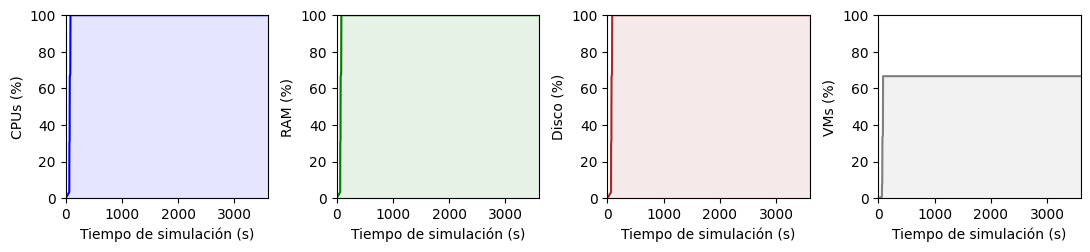

In [30]:
fig, (ax) = plt.subplots(1, 4, figsize=(10,7))
#fig.suptitle('Consumo recursos del Fog')

fig.tight_layout()
fig.set_size_inches(11, 2)

ax[0].set(ylabel='CPUs (%)')
ax[1].set(ylabel='RAM (%)')
ax[2].set(ylabel='Disco (%)')
ax[3].set(ylabel='VMs (%)')

#ax[0].plot(res_dc["cpus"].index, (res_dc["cpus"].values / dc_max_vms) * 100)
#ax[0].fill_between(res_dc["cpus"].index.to_numpy(), (res_dc["cpus"].values.reshape(-1) / dc_max_vms) * 100, 0, color='blue', alpha=.1)

plot_under_curve(ax[0], res_fog["cpus"].index, (res_fog["cpus"].values / fog_max_vms) * 100, "blue")
plot_under_curve(ax[1], res_fog["ram"].index, (res_fog["ram"].values / fog_max_ram) * 100, "green")
plot_under_curve(ax[2], res_fog["disk"].index, (res_fog["disk"].values / fog_max_disk) * 100, "brown")
plot_under_curve(ax[3], res_fog["vms"].index, (res_fog["vms"].values / fog_max_vms) * 100, "gray")

#plt.title("Uso de máquinas virtuales (DC)")

#plt.ylabel("Máquinas virtuales")
#plt.xlabel("tiempo simulado [s]")
for x in ax:
    x.set_ylim(0,100)
    x.set_xlim(0,3600)
    x.set(xlabel='Tiempo de simulación (s)')

fig.savefig("bigResFog1.pdf", bbox_inches='tight')